In [1]:
import random

def generate_sample_data(num,seed=1):
    #返却するリストを確保
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []
    
    #乱数を初期化
    random_instance = random.Random(seed)
    
    #返す関数の特徴を設定
    feature_num = 8
    base_weight = [0.02,0.03,0.05,-0.04,0.00,0.00,0.00,0.00]
    lift_weight = [0.00,0.00,0.00,0.05,-0.05,0.00,0.00,0.00]
    
    for i in range(num):
        #特徴ベクトルを乱数で生成
        feature_vector = [random_instance.random() for n in range(feature_num)]
        #実験群かどうかを乱数で決定
        is_treat = random_instance.choice((True, False))
        #内部的なコンバージョンレートを算出
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])
        
        if is_treat:
            #実験群であれば、lift_weightを加味する
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])
            
        #実際にコンバージョンしたかどうかを決定する
        is_cv = cv_rate > random_instance.random()
        
        #生成した値を格納
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
        
    #値を返す
    return is_cv_list, is_treat_list, feature_vector_list

generate_sample_data(2)

([False, False],
 [True, True],
 [[0.13436424411240122,
   0.8474337369372327,
   0.763774618976614,
   0.2550690257394217,
   0.49543508709194095,
   0.4494910647887381,
   0.651592972722763,
   0.7887233511355132],
  [0.8933170425576351,
   0.3898088070211341,
   0.6074379962852603,
   0.767157629147962,
   0.6958328667684435,
   0.26633056045725956,
   0.8018263669964836,
   0.5911534350013039]])

In [2]:
#9.4

#trainデータの生成
sample_num = 10000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

#データをtreatmentとcontrolに分離
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])

#コンバージョンレートを表示
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))


treatment_cvr 0.036918778686888844
control_cvr 0.03627981559430748


In [3]:
from sklearn.linear_model import LogisticRegression

#学習器の生成
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

#学習器の構築
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [4]:
#seedを変えてテストデータを生成
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

#それぞれの学習器でコンバージョンレートを予測
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

#スコアの算出、スコアは実験群の予測CVR　/　統制群の予測CVR
#predict_probaはクラス所属確率のリストを返すため1番目を参照する
#numpy.ndarrayなので、そのまま割り算しても、要素の割り算になる
score_list = treat_score[:,1] / control_score[:,1]

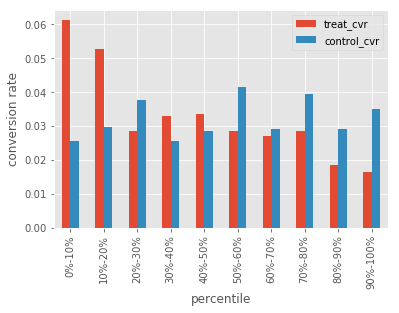

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
plt.style.use('ggplot')
%matplotlib inline

#スコアが高い順に並べる
result = list((zip(test_is_cv_list, test_is_treat_list, score_list)))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    #結果を10%ごとに切断
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    #実験群と統制群の数を数える
    treat_uu = list(map(lambda item: item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item: item[1], quantiled_result)).count(False)
    
    #実験群と統制群のコンバージョン数を計測
    treat_cv = [item[0] for item in quantiled_result if item[1] is True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] is False].count(True)
    
    #コンバージョンレートに変換し、表示用のDataFrameに格納
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%-{}%".format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]
    
qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("conversion rate")